In [1]:
import pandas as pd
import numpy as np
from sketching_algorithms import frobenius_norm,frequent_directions
import matplotlib.pyplot as plt
import time
from mlxtend.frequent_patterns import apriori,association_rules,fpgrowth
import warnings
import sys

warnings.filterwarnings('ignore')

# step 1 , load and clean data

In [2]:
df = pd.read_csv('Online Retail.csv')
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [3]:
print("column names : ", df.columns)

column names :  Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [4]:
# i will check if there is any null value in any columns
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# we consider null customer id as not completed or rejected invoices so we will remove them

In [6]:
df = df[df['CustomerID'].notna() & (df['CustomerID'] != '')]

In [7]:
# now remove unecessery cols
df = df.drop(["InvoiceDate","UnitPrice","CustomerID","Country"], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    406829 non-null  object
 1   StockCode    406829 non-null  object
 2   Description  406829 non-null  object
 3   Quantity     406829 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 15.5+ MB


In [9]:
# df.describe() , useless in this case

In [10]:
# here i will remove items with 0 or negative quantity
negative_quantity = (df['Quantity'] < 0).sum()
zero_quantity = (df['Quantity'] == 0).sum()
print(f"number of negative quantity values {negative_quantity}, number of zero quantity {zero_quantity}")

number of negative quantity values 8905, number of zero quantity 0


In [11]:
# only keep rows with above zero quantity
# drop description , because some stock numbers are empty
# there is no way we can interpolate or ... them precisely , maybe they are not product but i dont want to lose data , so i will keep
# using them , later i will query data set to get description if available

df = df[df['Quantity'] >= 0]
lookup_df = df.drop(["InvoiceNo","Quantity"], axis=1).drop_duplicates(subset=['StockCode']) # i will use this for finding desc base on stockno
df = df.drop(["Description","Quantity"], axis=1)
print(df.head()) # here step 1 is completed and we have a cleaned data

  InvoiceNo StockCode
0    536365    85123A
1    536365     71053
2    536365    84406B
3    536365    84029G
4    536365    84029E


In [12]:
def get_descrption(stock_code):
    # filter rows where first column matches stock_code
    rows = lookup_df[lookup_df.iloc[:, 0] == stock_code]
    
    if rows.empty:
        return -1  # stock_code not found
    # description can be nan for one row and non nan for other row
    # iterate over descriptions and return first non nan
    for descr in rows.iloc[:, 1]:
        if pd.notna(descr):
            return descr
    # If all are nan
    return "no description"

    
print(get_descrption("84534B")) # 84534B is an example of an stock_code wiht nan and non nan data

FAIRY CAKE NOTEBOOK A5 SIZE


In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   InvoiceNo  397924 non-null  object
 1   StockCode  397924 non-null  object
dtypes: object(2)
memory usage: 9.1+ MB
None


# step 2 , creating binary matrix

In [14]:
# here i want to make an new dataframe , rows are invoice no , cols are existance of an item
# binary_df = pd.get_dummies(df['Description'], dtype=int).groupby(df['InvoiceNo']).sum()

'''
bottom part will do one hot encoding ()
pd.get_dummies(df['Description'], dtype=int)
.groupby(df['InvoiceNo']).sum()
it will sum dupplicate invoiceno rows , it will casue the exact thing we want

i ran out of memory :| ...
'''

"\nbottom part will do one hot encoding ()\npd.get_dummies(df['Description'], dtype=int)\n.groupby(df['InvoiceNo']).sum()\nit will sum dupplicate invoiceno rows , it will casue the exact thing we want\n\ni ran out of memory :| ...\n"

In [15]:
# trying to Sparse[int] , because there will loots of zeros , there are other ways too but this will do the jobS
# binary_df = pd.get_dummies(df['StockCode'], dtype='Sparse[int]').groupby(df['InvoiceNo']).sum()
# this takes for ever!

In [16]:
df['StockCode'] = df['StockCode'].astype('category')
# as chatgpt says , cross table is exactly what we want in an optimal way :
# Takes two or more categorical inputs (usually Series or arrays).
# Counts how many times each unique pair of values occurs.
# Returns a DataFrame with one factor as rows, the other as columns, and counts as values.
# example :
# data = {
#     'Gender': ['Male', 'Female', 'Female', 'Male', 'Female'],
#     'Preference': ['Football', 'Football', 'Tennis', 'Tennis', 'Football']
# }
# out put look like below :
# | Preference | Football | Tennis |
# | ---------- | -------- | ------ |
# | Gender     |          |        |
# | Female     | 2        | 1      |
# | Male       | 1        | 1      |

binary_df = pd.crosstab(df['InvoiceNo'], df['StockCode'])
binary_df = binary_df.astype('Sparse[int]')
binary_df = (binary_df > 0).astype('Sparse[int]')


In [17]:
binary_df.info()
binary_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18536 entries, 536365 to 581587
Columns: 3665 entries, 10002 to POST
dtypes: Sparse[int32, 0](3665)
memory usage: 3.1+ MB


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
new_cols = [get_descrption(st) for st in binary_df.columns.values]

In [19]:
data = binary_df.to_numpy()
data_length = data.shape[0]
num_features = data.shape[1]
print(f"data_length: {data_length}, num features: {num_features}")

data_length: 18536, num features: 3665


# step 3 , simulating streaming

In [ ]:
# for pandas not truncating output

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)

In [25]:
# these are all hyperparameters can be set for this app!
hp = {
    "flow_size" : 500, # number of rows at each flow is being loaded
    "sketch_size" : 100, # numbre of rows of sketch 
    "sketch_binary_thresh": 0.5 , # >thresh is 1 else 0 
    # setting this 0 (positive 1 , negative 0) will make the sketches so dense and hard to compute assoc rules (apiriori ran out of mem !)
    # i will set higher for faster compute
    "min_sup": 0.05,
    "min_conf" : 0.05
}

In [26]:
sys.stdout = open("output.txt","w")
frob_norms = []

for epoch,flow_start_idx in enumerate(range(0,data_length,hp["flow_size"])):
    print(f"------------ epoch {epoch+1} / {int(data_length/hp["flow_size"])} ------------", flush=True)
    flow_end_idx = flow_start_idx+hp["flow_size"]
    if(flow_end_idx>data_length): flow_end_idx=data_length
    print(f"loading rows {flow_start_idx} to {flow_end_idx}", flush=True)
    flow = data[flow_start_idx:flow_end_idx]
    if (epoch==0):
        start_time = time.time()
        frob_norms.append(frobenius_norm(flow))
        flow_df = pd.DataFrame(flow, columns=new_cols,dtype="Sparse[int]")
        print("first flow density:", flow_df.values.sum() / (flow_df.shape[0]*flow_df.shape[1]), flush=True)
        frequent_itemsets = apriori(flow_df, min_support=hp["min_sup"], use_colnames=True)
        if (not frequent_itemsets.empty):
            print(f"[apiriori] first flow frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
            print(f"[apiriori] first flow association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
        else : 
            print(f"[apiriori] first flow frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)

        frequent_itemsets = fpgrowth(flow_df, min_support=hp["min_sup"], use_colnames=True)
        if (not frequent_itemsets.empty):
            print(f"[fpgrowth] first flow frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
            print(f"[fpgrowth] first flow association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
        else : 
            print(f"[fpgrowth] first flow frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)

        sketch = np.zeros((hp["sketch_size"], num_features))
        end_time = time.time()
        print(f"processing first flow took {end_time - start_time:.4f} seconds", flush=True)

    # now we do freq dir sketch
    start_time = time.time()
    sketch = frequent_directions(hp["sketch_size"],flow,sketch)
    # calc frob norm
    frob_norms.append(frobenius_norm(sketch))
    end_time = time.time()
    print(f"frequent directions took {end_time - start_time:.4f} seconds", flush=True)

    ################################################################################
    print(f"starting association rule learning", flush=True)
    start_time = time.time()
    sketch_bin = (sketch > hp["sketch_binary_thresh"]).astype(int)
    sketch_df = pd.DataFrame(sketch_bin, columns=new_cols,dtype="Sparse[int]")
    # print("Sketch non-zero count:", sketch_df.values.sum(), flush=True)
    print("Sketch density:", sketch_df.values.sum() / (sketch_df.shape[0]*sketch_df.shape[1]), flush=True)
    end_time = time.time()
    print(f"sketch is ready for association rule learning ( took {end_time - start_time:.4f} seconds )", flush=True)
    # freq pattern
    start_time = time.time()
    print("apiriori algorithm started", flush=True)
    frequent_itemsets = apriori(sketch_df, min_support=hp["min_sup"], use_colnames=True)
    if (not frequent_itemsets.empty):
        print(f"[apiriori] frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
        print(f"[apiriori] association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
    else :
        print(f"[apiriori] frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)
    end_time = time.time()
    print(f"apiriori took {end_time - start_time:.4f} seconds", flush=True)
    
    print("fpgrowth algorithm started", flush=True)
    start_time = time.time()
    frequent_itemsets = fpgrowth(sketch_df, min_support=hp["min_sup"], use_colnames=True)
    if (not frequent_itemsets.empty):
        print(f"[fpgrowth] frequent itemsets with minsup {hp["min_sup"]}\n{frequent_itemsets}\n", flush=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=hp["min_conf"])
        print(f"[fpgrowth] association rules with minconf {hp["min_conf"]}\n{rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]}\n", flush=True)
    else :
        print(f"[fpgrowth] frequent itemsets with minsup {hp["min_sup"]} had no result", flush=True)
    end_time = time.time()
    print(f"fpgrowth took {end_time - start_time:.4f} seconds", flush=True)
        

KeyboardInterrupt: 

note that first norm is for the first flow


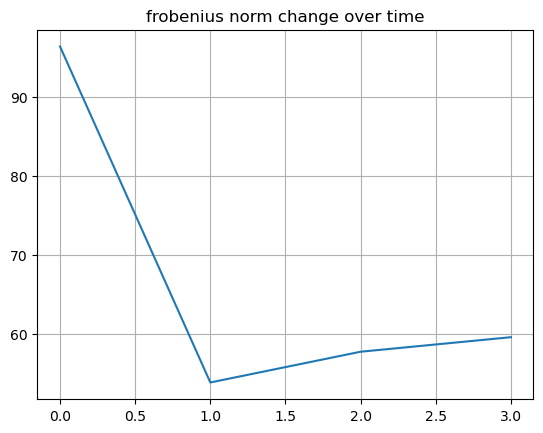

In [ ]:
print("note that first norm is for the first flow")
plt.title("frobenius norm change over time")
plt.plot(frob_norms)
plt.grid(True)
plt.show()

In [ ]:
sys.stdout.close()